In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from PIL import Image
from skimage.io import imread
from sklearn import svm
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from os import listdir

In [29]:
files = listdir("/Users/owenwebb/E90_data/archive-2/IDC_regular_ps50_idx5/")
print(len(files))

279


In [30]:
base_path = "/Users/owenwebb/E90_data/archive-2/IDC_regular_ps50_idx5/"
folder = listdir(base_path)
len(folder)

279

In [31]:
total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = base_path + patient_id 
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        total_images += len(subfiles)

In [32]:
total_images

277524

In [33]:
data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + patient_id 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1  

data.head()

,patient_id,path,target
0,9036,/Users/owenwebb/Documents/E90/data/archive-2/I...,0
1,9036,/Users/owenwebb/Documents/E90/data/archive-2/I...,0
2,9036,/Users/owenwebb/Documents/E90/data/archive-2/I...,0
3,9036,/Users/owenwebb/Documents/E90/data/archive-2/I...,0
4,9036,/Users/owenwebb/Documents/E90/data/archive-2/I...,0


In [34]:
data.shape

(277524, 3)

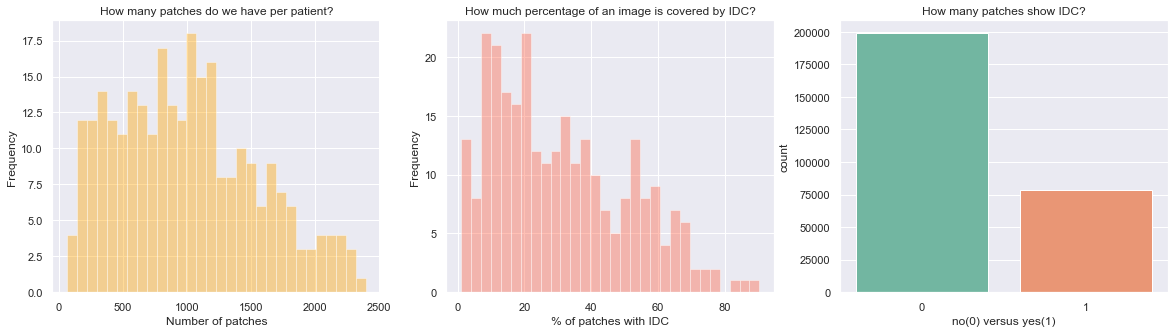

In [35]:
cancer_perc = data.groupby("patient_id").target.value_counts()/ data.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.distplot(data.groupby("patient_id").size(), ax=ax[0], color="Orange", kde=False, bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many patches do we have per patient?");
sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="Tomato", kde=False, bins=30)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC");
sns.countplot(data.target, palette="Set2", ax=ax[2]);
ax[2].set_xlabel("no(0) versus yes(1)")
ax[2].set_title("How many patches show IDC?");

In [36]:
data.target = data.target.astype(np.int)

In [37]:
pos_selection = np.random.choice(data[data.target==1].index.values, size=50, replace=False)
neg_selection = np.random.choice(data[data.target==0].index.values, size=50, replace=False)

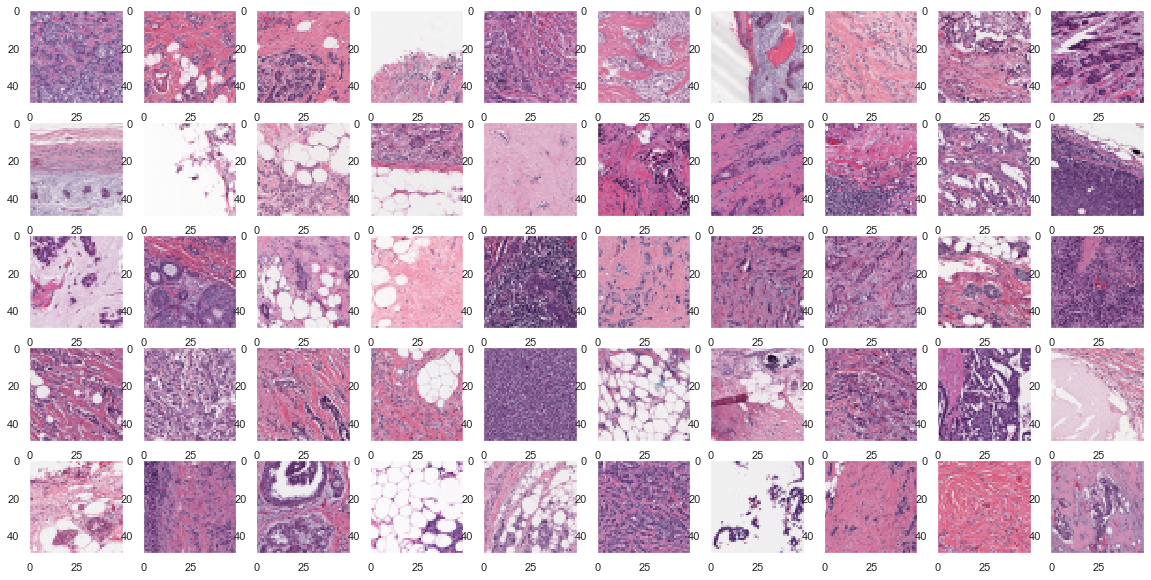

In [38]:
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

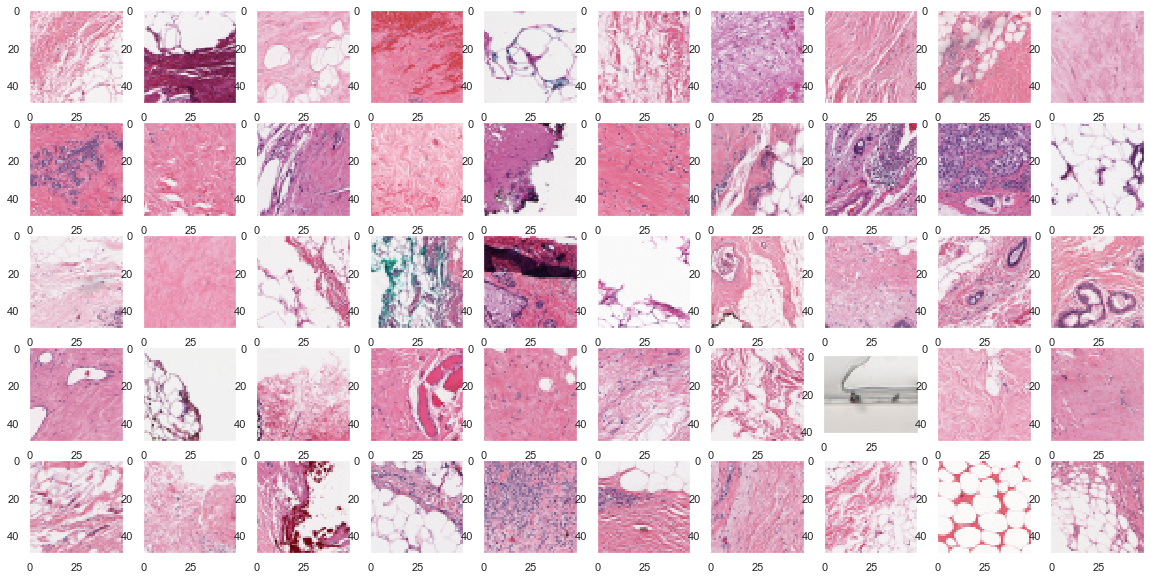

In [39]:
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

In [40]:
def extract_coords(df):
    coord = df.path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df

In [41]:
def get_cancer_dataframe(patient_id, cancer_id):
    path = base_path + patient_id + "/" + cancer_id
    files = listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = np.int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    return dataframe

In [42]:
def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df = df_0.append(df_1)
    return patient_df

In [43]:
example = get_patient_dataframe(data.patient_id.values[0])
example.head()

,x,y,target,path
0,1051,2401,0,/Users/owenwebb/Documents/E90/data/archive-2/I...
1,2951,951,0,/Users/owenwebb/Documents/E90/data/archive-2/I...
2,3001,1451,0,/Users/owenwebb/Documents/E90/data/archive-2/I...
3,3051,801,0,/Users/owenwebb/Documents/E90/data/archive-2/I...
4,951,1901,0,/Users/owenwebb/Documents/E90/data/archive-2/I...


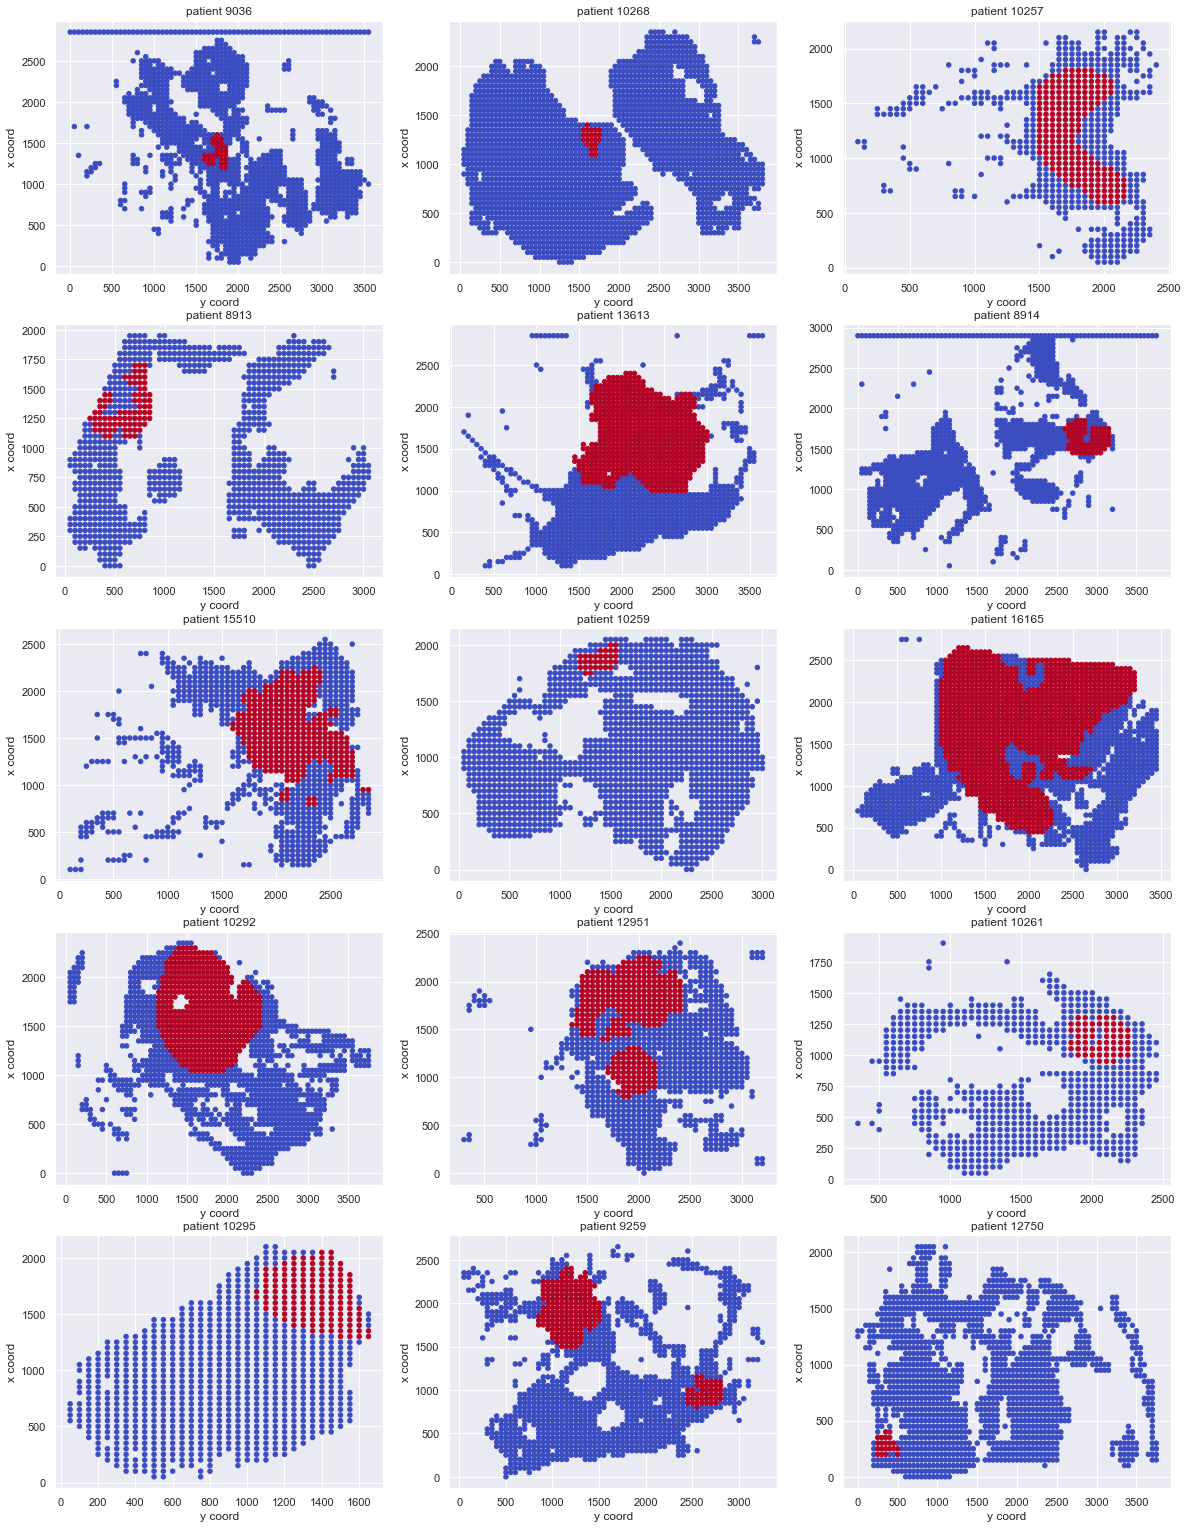

In [44]:
fig, ax = plt.subplots(5,3,figsize=(20, 27))

patient_ids = data.patient_id.unique()

for n in range(5):
    for m in range(3):
        patient_id = patient_ids[m + 3*n]
        example_df = get_patient_dataframe(patient_id)
        
        ax[n,m].scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20);
        ax[n,m].set_title("patient " + patient_id)
        ax[n,m].set_xlabel("y coord")
        ax[n,m].set_ylabel("x coord")

In [45]:
def visualise_breast_tissue(patient_id, pred_df=None):
    example_df = get_patient_dataframe(patient_id)
    max_point = [example_df.y.max()-1, example_df.x.max()-1]
    grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    if pred_df is not None:
        patient_df = pred_df[pred_df.patient_id == patient_id].copy()
    mask_proba = np.zeros(shape = (max_point[0] + 50, max_point[1] + 50, 1)).astype(np.float)
    
    broken_patches = []
    for n in range(len(example_df)):
        try:
            image = imread(example_df.path.values[n])
            
            target = example_df.target.values[n]
            
            x_coord = np.int(example_df.x.values[n])
            y_coord = np.int(example_df.y.values[n])
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50

            grid[y_start:y_end, x_start:x_end] = image
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0
            if pred_df is not None:
                
                proba = patient_df[
                    (patient_df.x==x_coord) & (patient_df.y==y_coord)].proba
                mask_proba[y_start:y_end, x_start:x_end, 0] = np.float(proba)

        except ValueError:
            broken_patches.append(example_df.path.values[n])
    
    
    return grid, mask, broken_patches, mask_proba

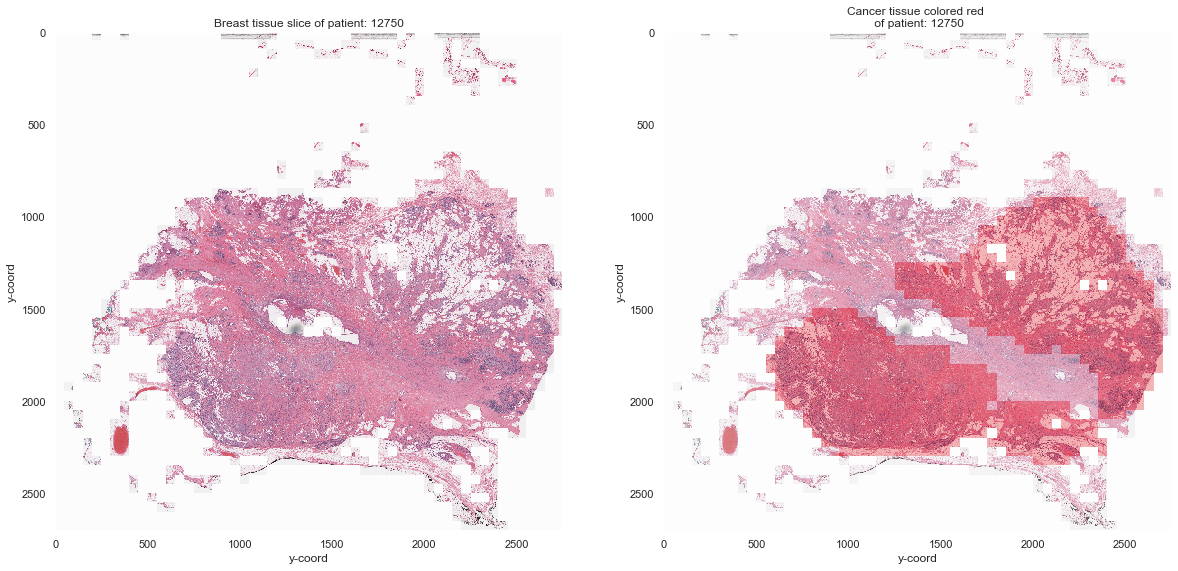

In [46]:
example = "13616"
grid, mask, broken_patches,_ = visualise_breast_tissue(example)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(grid, alpha=0.9)
ax[1].imshow(mask, alpha=0.8)
ax[1].imshow(grid, alpha=0.7)
ax[0].grid(False)
ax[1].grid(False)
for m in range(2):
    ax[m].set_xlabel("y-coord")
    ax[m].set_ylabel("y-coord")
ax[0].set_title("Breast tissue slice of patient: " + patient_id)
ax[1].set_title("Cancer tissue colored red \n of patient: " + patient_id);

In [47]:
data.head()
data.loc[:, "target"] = data.target.astype(np.str)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277524 entries, 0 to 277523
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   patient_id  277524 non-null  object
 1   path        277524 non-null  object
 2   target      277524 non-null  object
dtypes: object(3)
memory usage: 18.5+ MB


In [183]:
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale,resize

In [27]:
copy_data = data.copy()

In [186]:
image_lst = []

for path in copy_data["path"]:
    img_array = imread(path)
    resized_img = resize(img_array, (50,50,3))
    image_lst.append(resized_img)


copy_data["image"] = image_lst

KeyboardInterrupt: 

In [ ]:
copy_data.head()

In [50]:
from skimage import io
from skimage.color import rgb2gray

In [51]:
image_next_lst = []
for img in copy_data["image"]:
    img_gray = rgb2gray(img)
    image_next_lst.append(img_gray)

copy_data["image_next"] = image_next_lst

In [52]:
copy_data.head()

,patient_id,path,target,image,image_next
0,9036,/Users/owenwebb/Documents/E90/data/archive-2/I...,0,"[[[229, 193, 212], [233, 202, 223], [226, 184,...","[[0.7922349019607843, 0.823927843137255, 0.761..."
1,9036,/Users/owenwebb/Documents/E90/data/archive-2/I...,0,"[[[209, 167, 198], [218, 169, 197], [225, 191,...","[[0.6986670588235294, 0.711495294117647, 0.783..."
2,9036,/Users/owenwebb/Documents/E90/data/archive-2/I...,0,"[[[236, 222, 232], [207, 143, 181], [216, 171,...","[[0.8850823529411764, 0.6248619607843137, 0.71..."
3,9036,/Users/owenwebb/Documents/E90/data/archive-2/I...,0,"[[[143, 110, 153], [163, 103, 142], [185, 139,...","[[0.47103058823529415, 0.4649486274509804, 0.5..."
4,9036,/Users/owenwebb/Documents/E90/data/archive-2/I...,0,"[[[226, 169, 195], [220, 175, 200], [233, 188,...","[[0.7175964705882353, 0.730843137254902, 0.780..."


In [53]:
patients = copy_data.patient_id.unique()

train_ids, sub_test_ids = train_test_split(patients,
                                           test_size=0.3,
                                           random_state=0)
test_ids, dev_ids = train_test_split(sub_test_ids, test_size=0.5, random_state=0)

In [54]:
print(len(train_ids)/patients.shape[0]*100, len(dev_ids)/patients.shape[0]*100, len(test_ids)/patients.shape[0]*100)

69.89247311827957 15.053763440860216 15.053763440860216


In [55]:
train_df = copy_data.loc[copy_data.patient_id.isin(train_ids),:].copy()
test_df = copy_data.loc[copy_data.patient_id.isin(test_ids),:].copy()
dev_df = copy_data.loc[copy_data.patient_id.isin(dev_ids),:].copy()

train_df = extract_coords(train_df)
test_df = extract_coords(test_df)
dev_df = extract_coords(dev_df)

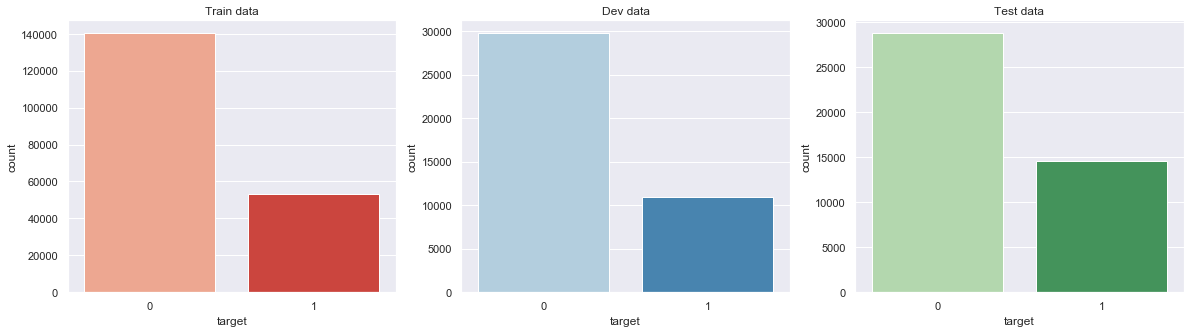

In [56]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.countplot(train_df.target, ax=ax[0], palette="Reds")
ax[0].set_title("Train data")
sns.countplot(dev_df.target, ax=ax[1], palette="Blues")
ax[1].set_title("Dev data")
sns.countplot(test_df.target, ax=ax[2], palette="Greens");
ax[2].set_title("Test data");

In [178]:
train_y = train_df["target"].astype(float)
train_x = train_df["image_next"].astype(object)

In [86]:
# param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly']}

In [179]:
svc=svm.SVC(probability=True)

In [88]:
# model=GridSearchCV(svc,param_grid,scoring='accuracy')

In [180]:
try:
    svc.fit(train_x, train_y)
except Exception as e:
    print("bad work on the fitting")

bad work on the fitting


# Trying Another Technique

In [120]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

import pandas as pd
import numpy as np

from PIL import Image

from skimage.feature import hog
from skimage import io
from skimage.color import rgb2gray

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc

In [116]:
base_path = "/Users/owenwebb/Documents/E90/data/archive-2/IDC_regular_ps50_idx5/"
folder = listdir(base_path)

In [143]:
def get_image(path):
    """
    Converts an image number into the file path where the image is located, 
    opens the image, and returns the image as a numpy array.
    """
    img = Image.open(path)
    # convert image to greyscale, makes a 2D array from 3D for SVM training
    gray_image = rgb2gray(img)
    return np.array(img)

In [147]:
image_lst = []

for path in copy_data["path"]:
    img_array = get_image(path)
    image_lst.append(img_array)


copy_data["image"] = image_lst

KeyboardInterrupt: 

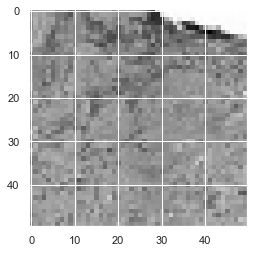

In [124]:
grey_patient= rgb2gray(get_image(patient_path))
plt.imshow(grey_patient,cmap=mpl.cm.gray)
plt.show()

In [142]:
# # Create a histogram of the features 
# hog_features, hog_image = hog(grey_patient,
#                               visualize=True,
#                               block_norm='L2-Hys',
#                               pixels_per_cell=(10, 10))

# plt.imshow(hog_image, cmap=mpl.cm.gray)

In [140]:
# def create_features(img):
#     # flatten the color image
#     color_features = img.flatten()
#     # convert image to greyscale, makes a 2D array from 3D for SVM training
#     gray_image = rgb2gray(img)
#     # get HOG features from grayscale image
#     hog_features = hog(gray_image, block_norm='L2-Hys', pixels_per_cell=(16, 16))
#     # combine color and hog features into a single array
#     flat_features = np.hstack(color_features)
#     return flat_features

In [141]:
# for n in range(len(folder)):
#     patient_id = folder[n]
#     patient_path = base_path + patient_id 
#     for c in [0,1]:
#         class_path = patient_path + "/" + str(c) + "/"
#         subfiles = listdir(class_path)
#         for m in range(len(subfiles)):
#             image_path = subfiles[m]
#             data.iloc[k]["path"] = class_path + image_path
#             data.iloc[k]["image"] = rgb2gray(get_image(class_path + image_path))
#             data.iloc[k]["target"] = c
#             data.iloc[k]["patient_id"] = patient_id
#             k += 1 

In [139]:
# def create_feature_matrix(label_dataframe):
#     features_list = []
    
#     for img_id in label_dataframe.index:
#         # load image
#         img = get_image(img_id)
#         # get features for image
#         image_features = create_features(img)
#         features_list.append(image_features)
        
#     # convert list of arrays into a matrix
#     feature_matrix = np.array(features_list)
#     return feature_matrix

# # run create_feature_matrix on our dataframe of images
# feature_matrix = create_feature_matrix(labels)

[212 133 170 ... 217 164 190]
